# Interpretazione di Reti Neurali con XAI (MNIST + DenseNet)

Questo notebook esegue una dimostrazione pratica delle tecniche di Explainable AI (XAI) integrate nel progetto.

Tecniche incluse: Integrated Gradients, Occlusion, Layer Grad-CAM, SHAP (GradientSHAP), LIME.

L'esecuzione scarica il dataset MNIST e un modello DenseNet121 pre-addestrato su ImageNet, calcola le mappe di salienza per alcuni campioni e salva i risultati in `outputs/`. Successivamente, il notebook visualizza i risultati salvati.

Nota: l'esecuzione della prima volta può richiedere alcuni minuti per il download di pesi e dataset.

In [1]:
# Controllo ambiente e import
import os, json, glob
import matplotlib.pyplot as plt
from PIL import Image

import torch

print('Torch version:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())


Torch version: 2.8.0+cu128
CUDA available: False


In [2]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution, GradientShap
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import slic
from matplotlib import cm

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


def get_device() -> torch.device:
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def get_transforms(img_size: int) -> transforms.Compose:
    return transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])


def load_model(device: torch.device, num_classes: int = None) -> nn.Module:
    try:
        from torchvision.models import DenseNet121_Weights
        weights = DenseNet121_Weights.DEFAULT
        model = models.densenet121(weights=weights)
        categories = weights.meta.get('categories', None)
    except Exception:
        model = models.densenet121(pretrained=True)
        categories = None
    if num_classes:
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
        for param in model.classifier.parameters():
            param.requires_grad = True
        model._categories = [str(i) for i in range(num_classes)]
    else:
        model._categories = categories
    model.eval()
    model.to(device)
    return model


def tensor_to_img(t: torch.Tensor) -> np.ndarray:
    if t.dim() == 4:
        t = t[0]
    t = t.detach().cpu().float()
    mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
    std = torch.tensor(IMAGENET_STD).view(3, 1, 1)
    img = t * std + mean
    img = img.clamp(0, 1).permute(1, 2, 0).numpy()
    return img


def _normalize_attr(attr: np.ndarray) -> np.ndarray:
    a = attr.astype(np.float32)
    if a.ndim == 3 and a.shape[0] in (1, 3):
        a = a.sum(axis=0)
    if a.ndim == 3 and a.shape[-1] in (1, 3):
        a = a.sum(axis=-1)
    a = a - a.min() if np.isfinite(a).all() else a
    denom = (a.max() - a.min()) if (np.max(a) - np.min(a)) > 0 else 1.0
    a = (a - a.min()) / denom
    return a


def overlay_heatmap(img: np.ndarray, attr: np.ndarray, alpha: float = 0.5, cmap_name: str = 'jet') -> np.ndarray:
    hmap = _normalize_attr(attr)
    if hmap.ndim == 3:
        hmap = hmap.mean(axis=-1)
    h, w = hmap.shape
    if img.shape[0] != h or img.shape[1] != w:
        img_resized = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((w, h))) / 255.0
    else:
        img_resized = img
    cmap = cm.get_cmap(cmap_name)
    heat = cmap(hmap)[..., :3]
    over = (1 - alpha) * img_resized + alpha * heat
    return np.clip(over, 0, 1)


def save_fig(path: str, img: np.ndarray, title: str = None):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    arr = (np.clip(img, 0, 1) * 255).astype(np.uint8)
    im = Image.fromarray(arr)
    im.save(path)


def compute_ig(model: nn.Module, input_tensor: torch.Tensor, target: int) -> np.ndarray:
    ig = IntegratedGradients(model)
    attributions = ig.attribute(input_tensor, target=target, n_steps=50)
    attr = attributions.sum(dim=1, keepdim=True)
    return attr.squeeze().detach().cpu().numpy()


def compute_occlusion(model: nn.Module, input_tensor: torch.Tensor, target: int) -> np.ndarray:
    occ = Occlusion(model)
    attributions = occ.attribute(
        input_tensor,
        strides=(3, 24, 24),
        target=target,
        sliding_window_shapes=(3, 48, 48),
        baselines=0,
    )
    attr = attributions.sum(dim=1, keepdim=True)
    return attr.squeeze().detach().cpu().numpy()


def compute_layer_gradcam(model: nn.Module, input_tensor: torch.Tensor, target: int) -> np.ndarray:
    target_layer = model.features.denseblock4
    lgc = LayerGradCam(model, target_layer)
    attributions = lgc.attribute(input_tensor, target=target)
    upsampled = LayerAttribution.interpolate(attributions, input_tensor.shape[-2:])
    attr = upsampled.sum(dim=1, keepdim=True)
    return attr.squeeze().detach().cpu().numpy()


def compute_shap(model: nn.Module, input_tensor: torch.Tensor, target: int) -> np.ndarray:
    gs = GradientShap(model)
    # Provide multiple baseline samples as a single tensor to avoid multi-input misinterpretation
    zero = torch.zeros_like(input_tensor)
    mid = torch.zeros_like(input_tensor) + 0.5
    baselines = torch.cat([zero, mid], dim=0)
    attributions = gs.attribute(input_tensor, baselines=baselines, target=target, n_samples=50, stdevs=0.0)
    attr = attributions.sum(dim=1, keepdim=True)
    return attr.squeeze().detach().cpu().numpy()


def compute_lime(model: nn.Module, input_tensor: torch.Tensor, device: torch.device) -> np.ndarray:
    img_np = tensor_to_img(input_tensor[0].detach().cpu())

    def predict_fn(imgs: list[np.ndarray]) -> np.ndarray:
        batch = []
        mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
        std = torch.tensor(IMAGENET_STD).view(3, 1, 1)
        for im in imgs:
            im = np.clip(im.astype(np.float32), 0, 1)
            t = torch.from_numpy(im.transpose(2, 0, 1)).float()
            t = (t - mean) / std
            batch.append(t)
        batch_t = torch.stack(batch, dim=0).to(device)
        with torch.no_grad():
            logits = model(batch_t)
            probs = F.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()

    explainer = LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_np,
        classifier_fn=predict_fn,
        top_labels=1,
        hide_color=0.0,
        num_samples=1000,
        segmentation_fn=lambda x: slic(x, n_segments=50, compactness=10, sigma=1),
    )
    label = explanation.top_labels[0]
    segments = explanation.segments
    weights = dict(explanation.local_exp[label])
    heatmap = np.zeros(segments.shape, dtype=float)
    for sp, w in weights.items():
        heatmap[segments == sp] = w
    return heatmap


def finetune_model(model: nn.Module, device: torch.device, train_loader: DataLoader, epochs: int = 1):
    print("Avvio del fine-tuning del modello...")
    model.train()

    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_preds += labels.size(0)
            correct_preds += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_preds / total_preds
        print(f"Fine-tuning - Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    model.eval()
    print("Fine-tuning completato.")


def run_demo(num_samples: int = 6, img_size: int = 224, batch_size: int = 8, output_dir: str = "outputs"):
    device = get_device()
    print(f"Using device: {device}")

    transform = get_transforms(img_size)

    train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_ds = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    model = load_model(device, num_classes=10)

    finetune_model(model, device, train_loader, epochs=1)

    os.makedirs(output_dir, exist_ok=True)

    processed = 0
    saved_meta = []

    with torch.no_grad():
        for images, labels in test_loader:
            if processed >= num_samples:
                break
            images = images.to(device)
            logits = model(images)
            probs = F.softmax(logits, dim=1)
            pred_probs, pred_idxs = probs.max(dim=1)

            for i in range(images.size(0)):
                if processed >= num_samples:
                    break

                x = images[i:i + 1]
                true_label = labels[i].item()
                pred_idx = int(pred_idxs[i].item())
                pred_prob = float(pred_probs[i].item())
                pred_label = str(pred_idx)

                ig_attr = compute_ig(model, x, pred_idx)
                oc_attr = compute_occlusion(model, x, pred_idx)
                gc_attr = compute_layer_gradcam(model, x, pred_idx)
                shap_attr = compute_shap(model, x, pred_idx)
                lime_attr = compute_lime(model, x, device)

                img_np = tensor_to_img(images[i].cpu())

                ig_vis = overlay_heatmap(img_np, ig_attr)
                oc_vis = overlay_heatmap(img_np, oc_attr)
                gc_vis = overlay_heatmap(img_np, gc_attr)
                shap_vis = overlay_heatmap(img_np, shap_attr)
                lime_vis = overlay_heatmap(img_np, lime_attr)

                base_name = f"mnist_{processed:02d}_true_{true_label}_pred_{pred_label}"
                save_fig(os.path.join(output_dir, f"{base_name}_input.png"), img_np)
                save_fig(os.path.join(output_dir, f"{base_name}_ig.png"), ig_vis)
                save_fig(os.path.join(output_dir, f"{base_name}_occlusion.png"), oc_vis)
                save_fig(os.path.join(output_dir, f"{base_name}_gradcam.png"), gc_vis)
                save_fig(os.path.join(output_dir, f"{base_name}_shap.png"), shap_vis)
                save_fig(os.path.join(output_dir, f"{base_name}_lime.png"), lime_vis)

                saved_meta.append({
                    "index": processed,
                    "true_label": true_label,
                    "pred_class_index": pred_idx,
                    "pred_class_label": pred_label,
                    "pred_prob": pred_prob,
                    "files": {
                        "input": f"{base_name}_input.png",
                        "integrated_gradients": f"{base_name}_ig.png",
                        "occlusion": f"{base_name}_occlusion.png",
                        "layer_gradcam": f"{base_name}_gradcam.png",
                        "shap": f"{base_name}_shap.png",
                        "lime": f"{base_name}_lime.png",
                    }
                })

                processed += 1

    report = {
        "num_samples": processed,
        "img_size": img_size,
        "output_dir": output_dir,
        "samples": saved_meta,
    }
    with open(os.path.join(output_dir, 'report.json'), 'w') as f:
        json.dump(report, f, indent=2)

    print(f"Saved results for {processed} samples to '{output_dir}'.")

/home/gab25/Projects/neural_network_interpretation/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parametri di esecuzione

In [3]:
# Modifica questi parametri per personalizzare l'esecuzione
NUM_SAMPLES = 4  # numero di immagini da processare
IMG_SIZE = 224  # dimensione di input (coerente con DenseNet/ImageNet)
BATCH_SIZE = 8  # batch per il dataloader
OUTPUT_DIR = 'outputs'

# Se necessario, assicurati che la cartella esista
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Esecuzione demo (calcolo e salvataggio mappe XAI)

In [4]:
# Questo chiamerà il modello DenseNet121, caricherà MNIST (test set) e salverà i risultati in OUTPUT_DIR
run_demo(num_samples=NUM_SAMPLES, img_size=IMG_SIZE, batch_size=BATCH_SIZE, output_dir=OUTPUT_DIR)

Using device: cpu
Avvio del fine-tuning del modello...
Fine-tuning - Epoch 1/1, Loss: 0.4036, Accuracy: 0.8783
Fine-tuning completato.


100%|██████████| 1000/1000 [00:33<00:00, 29.80it/s]
/tmp/ipykernel_9271/1538926686.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)
100%|██████████| 1000/1000 [00:33<00:00, 29.95it/s]
/tmp/ipykernel_9271/1538926686.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)
100%|██████████| 1000/1000 [00:32<00:00, 30.34it/s]
/tmp/ipykernel_9271/1538926686.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


Saved results for 4 samples to 'outputs'.



/tmp/ipykernel_9271/1538926686.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


## Visualizzazione risultati salvati

Trovati 4 campioni nel report.
Campione 0 | Vero: 7 | Pred: 7 (p=0.99)


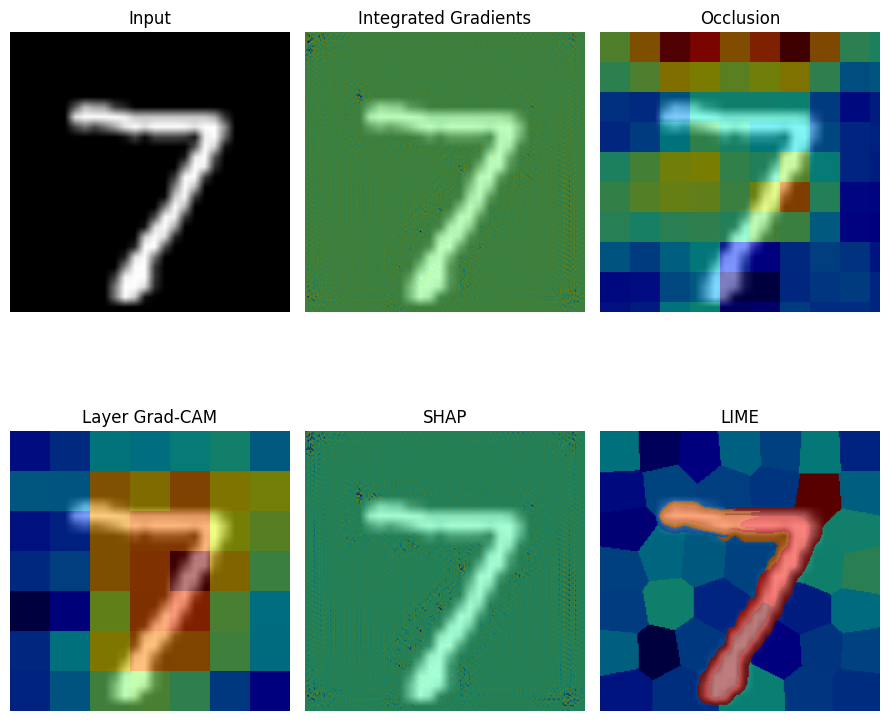

Campione 1 | Vero: 2 | Pred: 2 (p=0.99)


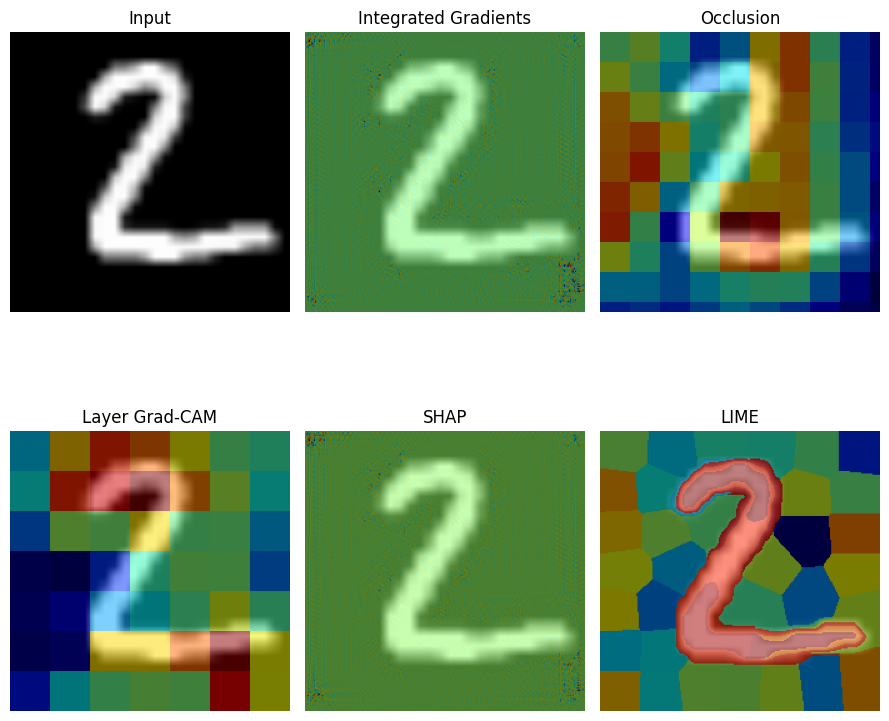

Campione 2 | Vero: 1 | Pred: 1 (p=1.00)


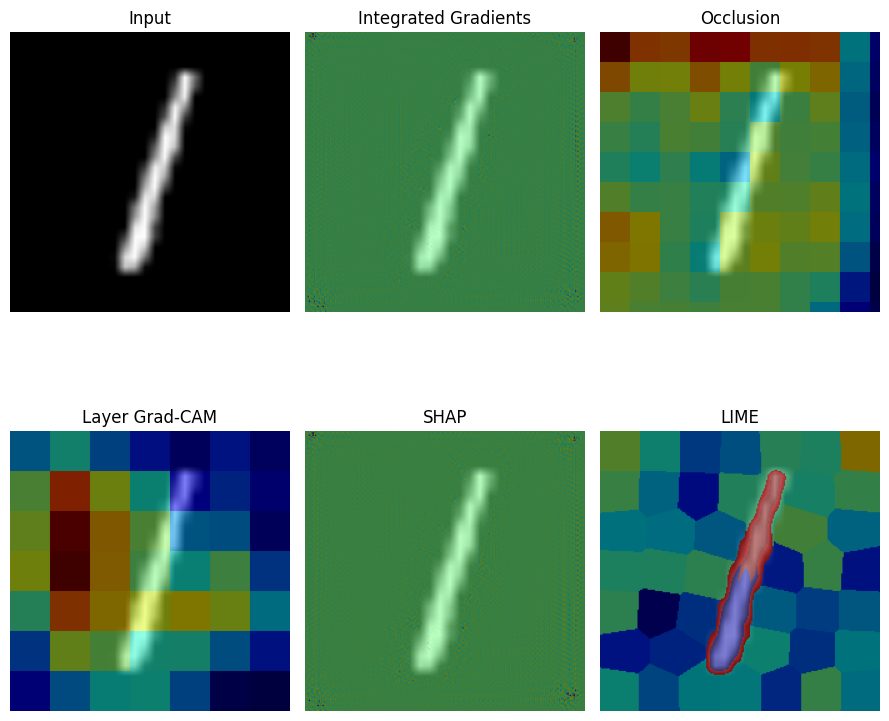

Campione 3 | Vero: 0 | Pred: 0 (p=0.99)


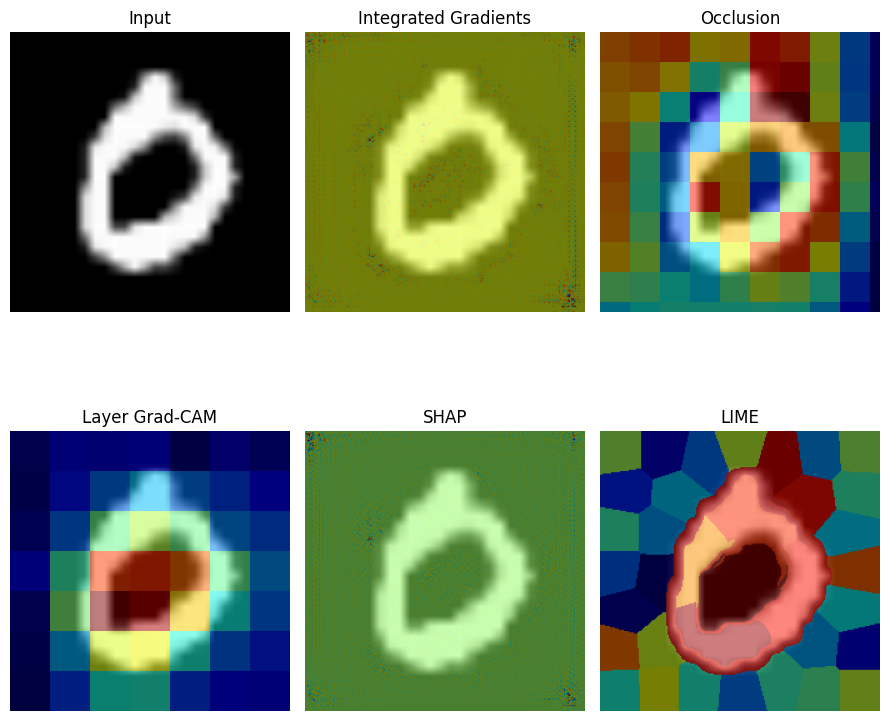

In [5]:
# Carichiamo il report JSON e visualizziamo le immagini generate per ciascun campione
report_path = os.path.join(OUTPUT_DIR, 'report.json')
with open(report_path, 'r') as f:
    report = json.load(f)
samples = report.get('samples', [])
print(f'Trovati {len(samples)} campioni nel report.')


def show_images_grid(paths, titles=None, ncols=3, figsize=(9, 9)):
    n = len(paths)
    if n == 0:
        return
    ncols = min(ncols, n)
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)

    # Normalize axes to a 2D NumPy array of shape (nrows, ncols)
    import numpy as _np
    axes = _np.atleast_2d(_np.array(axes, dtype=object)).reshape(nrows, ncols)

    idx = 0
    for r in range(nrows):
        for c in range(ncols):
            ax = axes[r, c]
            if idx < n:
                img = Image.open(os.path.join(OUTPUT_DIR, paths[idx]))
                ax.imshow(img)
                ax.axis('off')
                if titles and idx < len(titles):
                    ax.set_title(titles[idx])
            else:
                ax.axis('off')
            idx += 1
    plt.tight_layout()
    plt.show()


for sample in samples:
    print(
        f"Campione {sample['index']} | Vero: {sample['true_label']} | Pred: {sample['pred_class_label']} (p={sample['pred_prob']:.2f})")
    files = sample['files']
    order = ['input', 'integrated_gradients', 'occlusion', 'layer_gradcam', 'shap', 'lime']
    paths = [files[k] for k in order if k in files]
    titles = ['Input', 'Integrated Gradients', 'Occlusion', 'Layer Grad-CAM', 'SHAP', 'LIME']
    show_images_grid(paths, titles)

## (Opzionale) Esecuzione rapida su un singolo batch senza salvataggio
Questo blocco di codice mostra come potresti riutilizzare le funzioni interne per calcolare e visualizzare una sola istanza direttamente nel notebook, senza scrivere su disco.

Avvio del fine-tuning del modello...
Fine-tuning - Epoch 1/1, Loss: 0.4050, Accuracy: 0.8774
Fine-tuning completato.


100%|██████████| 1000/1000 [00:33<00:00, 30.29it/s]
/tmp/ipykernel_9271/1538926686.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


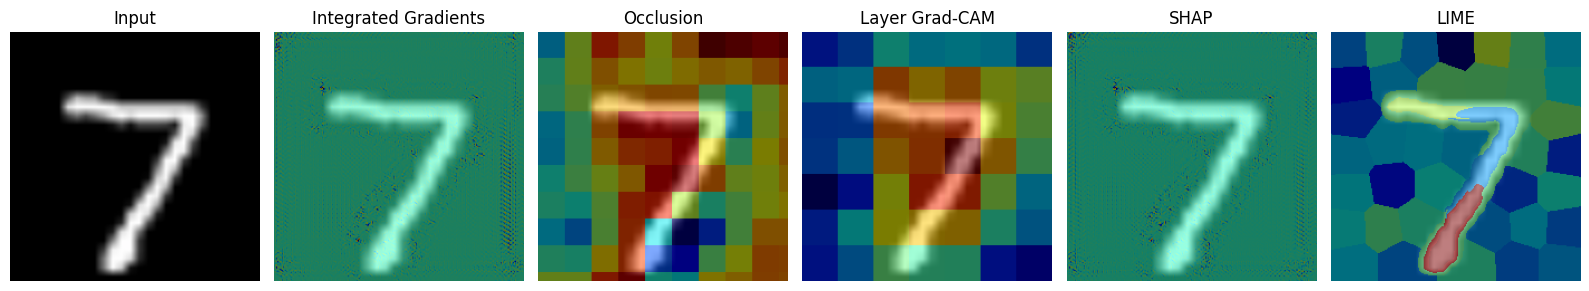

In [6]:
# Opzionale: calcolo inline di un singolo esempio
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = get_device()
transform = get_transforms(IMG_SIZE)

train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
x, y = test[0]
x = x.unsqueeze(0).to(device)

# Carica e adatta il modello per MNIST (10 classi)
model = load_model(device, num_classes=10)
# Esegui il fine-tuning
finetune_model(model, device, train_loader, epochs=1)

# Usiamo la predizione del modello come target
with torch.no_grad():
    logits = model(x)
    pred_idx = int(torch.softmax(logits, dim=1).argmax(dim=1).item())

ig_attr = compute_ig(model, x, pred_idx)
oc_attr = compute_occlusion(model, x, pred_idx)
gc_attr = compute_layer_gradcam(model, x, pred_idx)
shap_attr = compute_shap(model, x, pred_idx)
lime_attr = compute_lime(model, x, device)

img_np = tensor_to_img(x[0].detach().cpu())
methods = ['Integrated Gradients', 'Occlusion', 'Layer Grad-CAM', 'SHAP', 'LIME']
attrs = [ig_attr, oc_attr, gc_attr, shap_attr, lime_attr]
vis = [overlay_heatmap(img_np, a) for a in attrs]

fig, axes = plt.subplots(1, 6, figsize=(16, 3))
axes[0].imshow(img_np);
axes[0].set_title('Input');
axes[0].axis('off')
for i, m in enumerate(methods, start=1):
    axes[i].imshow(vis[i - 1]);
    axes[i].set_title(m);
    axes[i].axis('off')
plt.tight_layout();
plt.show()
